# Data Teks

In [ ]:
# Import Library Yang Dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import seaborn as sns

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
# Load dataset dari Google Drive
url = "https://docs.google.com/spreadsheets/d/1VtBTcgVDBWQfzceXkQuA_zKwVL00Ulm9gAC0ksN8TzM/export?format=csv"
df = pd.read_csv(url)

# Tampilkan 5 data pertama
df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5
1,neutral,i ve learned this lesson again open the packag...,88,1
2,neutral,it is so slow and lags find better option,9,2
3,neutral,roller ball stopped working within months of m...,12,1
4,neutral,i like the color and size but it few days out ...,21,1


In [ ]:
# Lihat distribusi kelas
print("Distribusi Sentiments:")
df['sentiments'].value_counts()

Distribusi Sentiments:


,count
sentiments,
positive,9503
neutral,6303
negative,1534


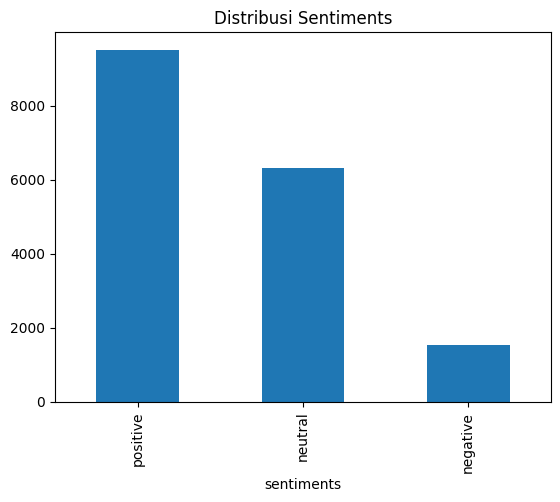

In [ ]:
# Visualisasi distribusi kelas
df['sentiments'].value_counts().plot(kind='bar', title='Distribusi Sentiments')
plt.show()

In [ ]:
# Periksa statistik umum
print("Statistik Dataset:")
df.describe()

Statistik Dataset:


,cleaned_review_length,review_score
count,17340.000000,17340.000000
mean,30.300461,3.649077
std,35.836540,1.673500
min,0.000000,1.000000
25%,9.000000,2.000000
50%,20.000000,5.000000
75%,38.000000,5.000000
max,571.000000,5.000000


In [ ]:
# Periksa missing values
df.isnull().sum()

,0
sentiments,0
cleaned_review,19
cleaned_review_length,0
review_score,0


In [ ]:
# Mengisi nilai NaN jadi nilai kosong
df.fillna('', inplace=True)

In [ ]:
# Periksa missing values
df.isnull().sum()

,0
sentiments,0
cleaned_review,0
cleaned_review_length,0
review_score,0


In [ ]:
# Menyiapkan teks dan label
X = df['cleaned_review']
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Encode labels
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)  # Convert to tensor

In [ ]:
# Tokenisasi menggunakan BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128, return_tensors="tf")
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128, return_tensors="tf")

In [ ]:
# Load model BERT
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from tf_keras.src.callbacks import EarlyStopping
from transformers import AdamWeightDecay

# Compile model
optimizer = AdamWeightDecay(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Training
history = model.fit(
    {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']},
    y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=16,
    callbacks=[early_stopping]
)

Epoch 1/10
694/694 [==============================] - 344s 469ms/step - loss: 0.4137 - accuracy: 0.8274 - val_loss: 0.3852 - val_accuracy: 0.8652
Epoch 2/10
694/694 [==============================] - 322s 464ms/step - loss: 0.2090 - accuracy: 0.9192 - val_loss: 0.2943 - val_accuracy: 0.8937
Epoch 3/10
694/694 [==============================] - 322s 464ms/step - loss: 0.1510 - accuracy: 0.9435 - val_loss: 0.2352 - val_accuracy: 0.9211
Epoch 4/10
694/694 [==============================] - 324s 466ms/step - loss: 0.0847 - accuracy: 0.9696 - val_loss: 0.2836 - val_accuracy: 0.9146
Epoch 5/10
694/694 [==============================] - 322s 464ms/step - loss: 0.0597 - accuracy: 0.9796 - val_loss: 0.2622 - val_accuracy: 0.9225
Epoch 6/10
694/694 [==============================] - 322s 465ms/step - loss: 0.0508 - accuracy: 0.9822 - val_loss: 0.3130 - val_accuracy: 0.9020


In [ ]:
# Classification report
y_pred = np.argmax(model.predict(test_encodings.data).logits, axis=1)
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

# Evaluasi model
loss, accuracy = model.evaluate(test_encodings.data, y_test)
print(f"Accuracy: {accuracy}")

109/109 [==============================] - 30s 276ms/step

Classification Report:
               precision    recall  f1-score   support

    negative       0.82      0.78      0.79       307
     neutral       0.89      0.89      0.89      1261
    positive       0.95      0.96      0.96      1900

    accuracy                           0.92      3468
   macro avg       0.88      0.87      0.88      3468
weighted avg       0.92      0.92      0.92      3468

109/109 [==============================] - 30s 276ms/step - loss: 0.2332 - accuracy: 0.9167
Accuracy: 0.9166666865348816


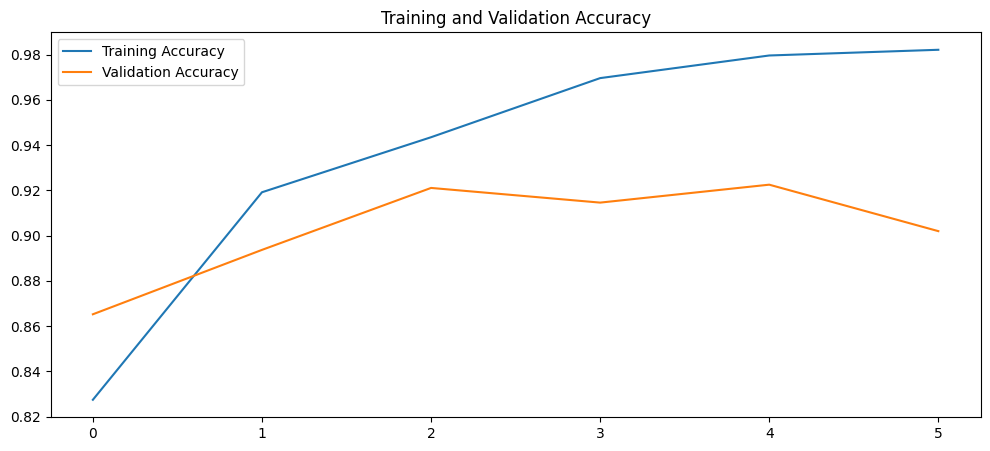

In [ ]:
# Plot akurasi dan loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

In [ ]:
# Prediksi data uji
predicted_labels = label_encoder.inverse_transform(y_pred)

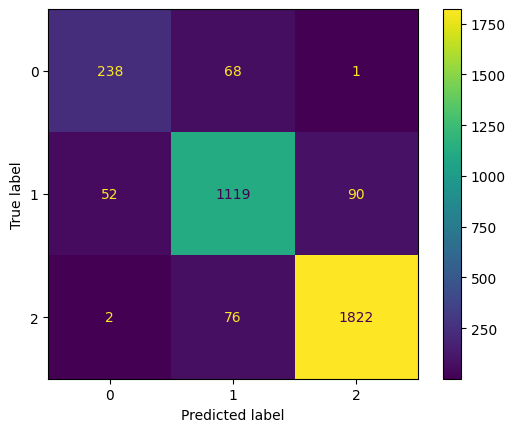

In [ ]:
# Perbandingan hasil prediksi dengan true label
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_)
plt.show()

In [ ]:
# Membandingkan hasil prediksi
comparison = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': y_pred
})
print(comparison.head())

# Analisis perbedaan
comparison['Correct'] = comparison['True Label'] == comparison['Predicted Label']
print(comparison['Correct'].value_counts())

       True Label  Predicted Label
11915           0                1
3630            2                2
3264            2                2
14247           1                1
4856            0                0
Correct
True     3179
False     289
Name: count, dtype: int64


In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

Classification Report:
              precision    recall  f1-score   support

    negative       0.82      0.78      0.79       307
     neutral       0.89      0.89      0.89      1261
    positive       0.95      0.96      0.96      1900

    accuracy                           0.92      3468
   macro avg       0.88      0.87      0.88      3468
weighted avg       0.92      0.92      0.92      3468



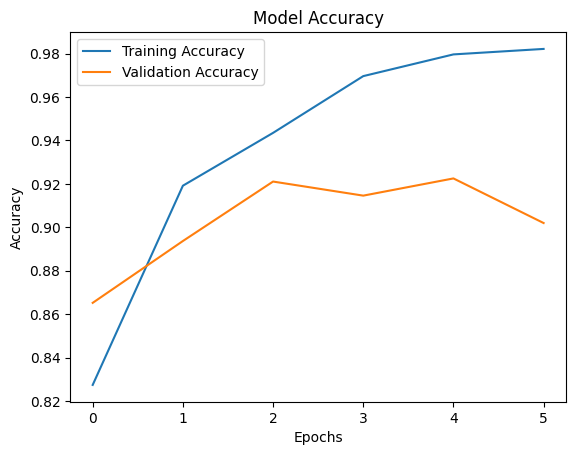

In [ ]:
# Tampilkan hasil evaluasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Data Tabular

## Original Data

In [ ]:
!pip install pytorch-tabnet

In [ ]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch

In [ ]:
# Load dataset dari Google Drive
url = "https://docs.google.com/spreadsheets/d/12QMTKb79y64rtYn8QroqJl1g_zP7Ri_pWrJ1MmtS70g/export?format=csv"
dataset = pd.read_csv(url)

# Tampilkan beberapa data awal
dataset.head()


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,67,Private,366425,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,244602,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,174201,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,110199,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,149248,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43957 entries, 0 to 43956
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              43957 non-null  int64 
 1   workclass        41459 non-null  object
 2   fnlwgt           43957 non-null  int64 
 3   education        43957 non-null  object
 4   educational-num  43957 non-null  int64 
 5   marital-status   43957 non-null  object
 6   occupation       41451 non-null  object
 7   relationship     43957 non-null  object
 8   race             43957 non-null  object
 9   gender           43957 non-null  object
 10  capital-gain     43957 non-null  int64 
 11  capital-loss     43957 non-null  int64 
 12  hours-per-week   43957 non-null  int64 
 13  native-country   43194 non-null  object
 14  income_>50K      43957 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 5.0+ MB


income_>50K
0    33439
1    10518
Name: count, dtype: int64


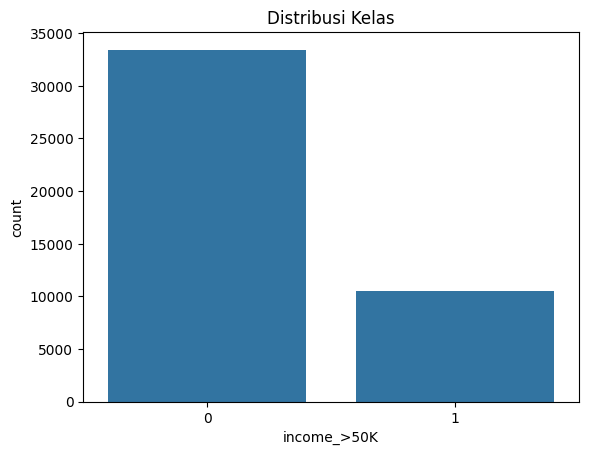

In [ ]:
# Distribusi kelas
print(dataset['income_>50K'].value_counts())
sns.countplot(x='income_>50K', data=dataset)
plt.title("Distribusi Kelas")
plt.show()

In [ ]:
# Analisis statistik
dataset.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income_>50K
count,43957.000000,4.395700e+04,43957.000000,43957.000000,43957.000000,43957.000000,43957.000000
mean,38.617149,1.896730e+05,10.074118,1093.559797,88.246491,40.407694,0.239279
std,13.734401,1.058215e+05,2.575092,7570.536063,404.588410,12.400303,0.426648
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.174960e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.781000e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.376710e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [ ]:
# Periksa missing values
dataset.isnull().sum()

,0
age,0
workclass,2498
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,2506
relationship,0
race,0
gender,0


In [ ]:
# Encoding untuk kolom kategori
label_encoders = {}
for col in ['workclass', 'education', 'marital-status', 'occupation',
            'relationship', 'race', 'gender', 'native-country']:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col].astype(str))
    label_encoders[col] = le

# Handling missing values (jika ada)
dataset.fillna(dataset.median(), inplace=True)

# Normalisasi fitur numerik
scaler = StandardScaler()
numeric_features = ['age', 'fnlwgt', 'educational-num', 'capital-gain',
                    'capital-loss', 'hours-per-week']
dataset[numeric_features] = scaler.fit_transform(dataset[numeric_features])

In [ ]:
# Periksa Dataset
dataset.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income_>50K
0,2.066575,3,1.670303,10,2.301258,0,3,1,4,1,13.064671,-0.218117,1.580004,38,1
1,-1.573960,3,0.519078,2,-0.805463,4,7,3,4,1,-0.144451,-0.218117,-2.048981,38,0
2,-0.554610,3,-0.146210,9,1.136237,2,3,0,4,1,-0.144451,-0.218117,-0.032878,38,1
3,1.411279,6,-0.751028,5,-2.358824,2,13,0,4,1,-0.144451,-0.218117,-0.032878,38,0
4,-0.991474,6,-0.382016,15,-0.028783,4,7,1,2,1,-0.144451,-0.218117,-0.032878,38,0


In [ ]:
# Periksa missing values
dataset.isnull().sum()

,0
age,0
workclass,0
fnlwgt,0
education,0
educational-num,0
marital-status,0
occupation,0
relationship,0
race,0
gender,0


In [ ]:
# Membagi data menjadi fitur dan target
X = dataset.drop(columns=['income_>50K'])
y = dataset['income_>50K']

# Split data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Inisialisasi model TabNet
tabnet = TabNetClassifier()

# Training model TabNet
tabnet.fit(
    X_train.values, y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_metric=['accuracy'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    eval_name=['valid']
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.47361 | valid_accuracy: 0.64058 |  0:00:05s
epoch 1  | loss: 0.37296 | valid_accuracy: 0.78958 |  0:00:06s
epoch 2  | loss: 0.35248 | valid_accuracy: 0.80539 |  0:00:08s
epoch 3  | loss: 0.34454 | valid_accuracy: 0.8237  |  0:00:09s
epoch 4  | loss: 0.34048 | valid_accuracy: 0.83508 |  0:00:11s
epoch 5  | loss: 0.33893 | valid_accuracy: 0.83678 |  0:00:13s
epoch 6  | loss: 0.33376 | valid_accuracy: 0.83997 |  0:00:15s
epoch 7  | loss: 0.33208 | valid_accuracy: 0.83633 |  0:00:17s
epoch 8  | loss: 0.32929 | valid_accuracy: 0.84554 |  0:00:18s
epoch 9  | loss: 0.32575 | valid_accuracy: 0.84145 |  0:00:20s
epoch 10 | loss: 0.326   | valid_accuracy: 0.84247 |  0:00:21s
epoch 11 | loss: 0.32821 | valid_accuracy: 0.8444  |  0:00:23s
epoch 12 | loss: 0.32845 | valid_accuracy: 0.84429 |  0:00:24s
epoch 13 | loss: 0.32635 | valid_accuracy: 0.84759 |  0:00:26s
epoch 14 | loss: 0.32203 | valid_accuracy: 0.8452  |  0:00:28s
epoch 15 | loss: 0.327   | valid_accuracy: 0.83985 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6688
           1       0.75      0.54      0.63      2104

    accuracy                           0.85      8792
   macro avg       0.81      0.74      0.77      8792
weighted avg       0.84      0.85      0.84      8792



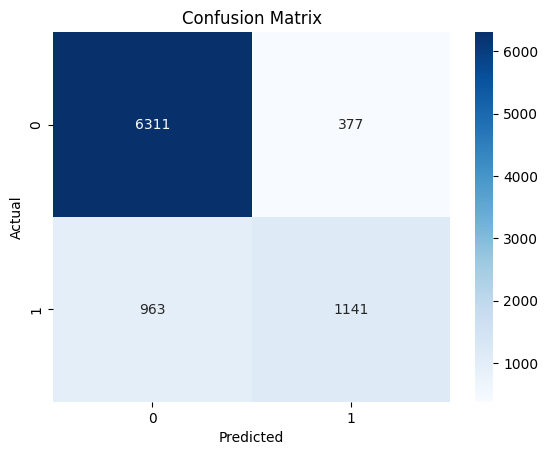

In [ ]:
# Evaluasi kinerja model
y_pred = tabnet.predict(X_test.values)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Prediksi pada data uji
predictions = tabnet.predict(X_test.values)

In [ ]:
# Membandingkan hasil prediksi
comparison = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': predictions
})
print(comparison.head())

# Analisis perbedaan
comparison['Correct'] = comparison['True Label'] == comparison['Predicted Label']
print(comparison['Correct'].value_counts())


       True Label  Predicted Label
23751           1                0
43746           1                1
12885           1                0
5393            0                0
13467           0                0
Correct
True     7452
False    1340
Name: count, dtype: int64


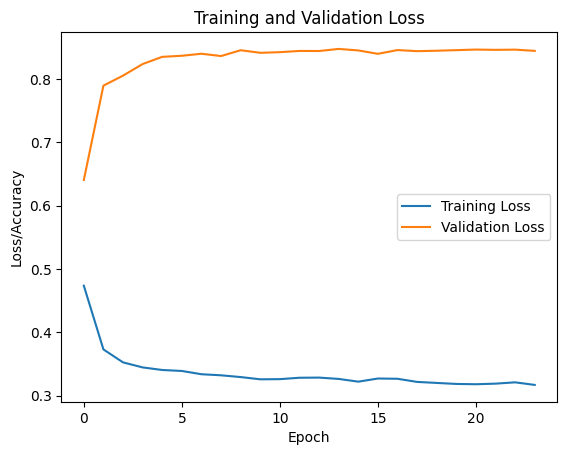

In [ ]:
# Plot akurasi selama training
plt.plot(tabnet.history['loss'], label='Training Loss')
plt.plot(tabnet.history['valid_accuracy'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
# Tampilkan classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

# Tampilkan metrik lainnya
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      6688
           1       0.75      0.54      0.63      2104

    accuracy                           0.85      8792
   macro avg       0.81      0.74      0.77      8792
weighted avg       0.84      0.85      0.84      8792

Accuracy: 0.8475887170154686


## Augmented Data

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Terapkan SMOTE
smote = SMOTE(random_state=42)

# Assuming 'dataset' is your DataFrame
X = dataset.drop(columns=['income_>50K'])
y = dataset['income_>50K']

#Now use the variables (X, y) that refer to the actual data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Setelah oversampling
print("Distribusi kelas setelah oversampling:", Counter(y_resampled))

# Split data setelah oversampling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

Distribusi kelas setelah oversampling: Counter({1: 33439, 0: 33439})


In [ ]:
# Inisialisasi model TabNet
tabnet = TabNetClassifier()

# Training model TabNet
tabnet.fit(
    X_train.values, y_train.values,
    eval_set=[(X_test.values, y_test.values)],
    eval_metric=['accuracy'],
    max_epochs=50,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    eval_name=['valid']
)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.49402 | valid_accuracy: 0.63248 |  0:00:02s
epoch 1  | loss: 0.41768 | valid_accuracy: 0.7799  |  0:00:05s
epoch 2  | loss: 0.39663 | valid_accuracy: 0.80891 |  0:00:07s
epoch 3  | loss: 0.39034 | valid_accuracy: 0.81878 |  0:00:10s
epoch 4  | loss: 0.38525 | valid_accuracy: 0.82095 |  0:00:12s
epoch 5  | loss: 0.37948 | valid_accuracy: 0.82289 |  0:00:14s
epoch 6  | loss: 0.37745 | valid_accuracy: 0.82648 |  0:00:17s
epoch 7  | loss: 0.37239 | valid_accuracy: 0.82521 |  0:00:20s
epoch 8  | loss: 0.37171 | valid_accuracy: 0.82887 |  0:00:22s
epoch 9  | loss: 0.37033 | valid_accuracy: 0.82723 |  0:00:24s
epoch 10 | loss: 0.37005 | valid_accuracy: 0.8276  |  0:00:27s
epoch 11 | loss: 0.3695  | valid_accuracy: 0.82409 |  0:00:30s
epoch 12 | loss: 0.37266 | valid_accuracy: 0.82827 |  0:00:32s
epoch 13 | loss: 0.36899 | valid_accuracy: 0.82551 |  0:00:35s
epoch 14 | loss: 0.36922 | valid_accuracy: 0.82812 |  0:00:37s
epoch 15 | loss: 0.3661  | valid_accuracy: 0.82491 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


              precision    recall  f1-score   support

           0       0.88      0.78      0.82      6688
           1       0.80      0.89      0.84      6688

    accuracy                           0.83     13376
   macro avg       0.84      0.83      0.83     13376
weighted avg       0.84      0.83      0.83     13376



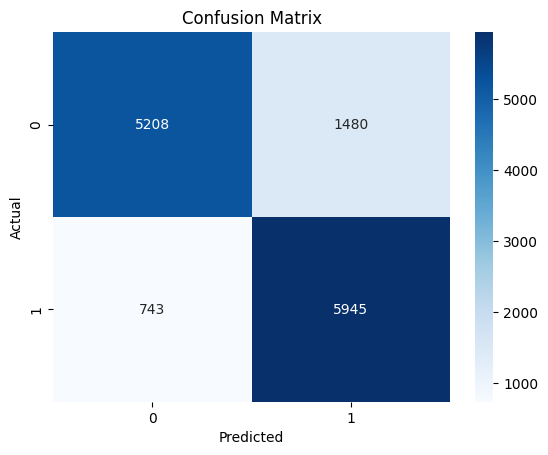

In [ ]:
# Evaluasi kinerja model
y_pred = tabnet.predict(X_test.values)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Prediksi pada data uji
predictions_aug = tabnet.predict(X_test.values)

In [ ]:
# Membandingkan hasil prediksi
comparison = pd.DataFrame({
    'True Label': y_test,
    'Predicted Label': predictions_aug
})
print(comparison.head())

# Analisis perbedaan
comparison['Correct'] = comparison['True Label'] == comparison['Predicted Label']
print(comparison['Correct'].value_counts())


       True Label  Predicted Label
65843           1                1
27123           1                1
20832           0                0
64521           1                0
44423           1                1
Correct
True     11153
False     2223
Name: count, dtype: int64


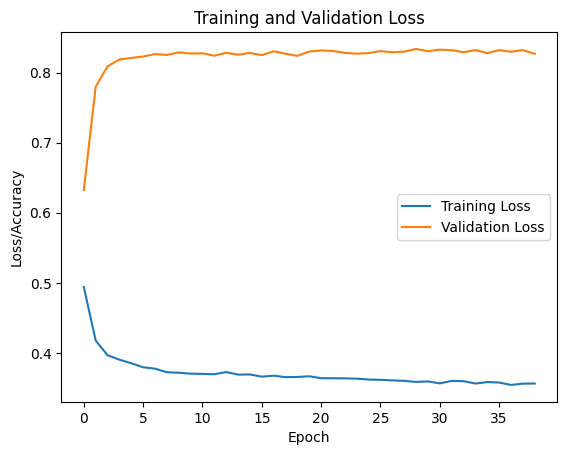

In [ ]:
# Plot akurasi selama training
plt.plot(tabnet.history['loss'], label='Training Loss')
plt.plot(tabnet.history['valid_accuracy'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
# Tampilkan classification report
print("Classification Report:")
print(classification_report(y_test, predictions_aug))

# Tampilkan metrik lainnya
accuracy = accuracy_score(y_test, predictions_aug)
print(f"Accuracy: {accuracy}")

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      6688
           1       0.80      0.89      0.84      6688

    accuracy                           0.83     13376
   macro avg       0.84      0.83      0.83     13376
weighted avg       0.84      0.83      0.83     13376

Accuracy: 0.8338068181818182
